# Plotting and comparing best fit models to data for fits to BAOs with and without the phase shift parameter 

### load stuff 

In [86]:
# Import some necessary modules
import os
import sys
sys.path.append("../../Barry/")     # Change this so that it points to where you have Barry installed
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer     
from barry.cosmology.camb_generator import Omega_m_z


from barry.samplers import DynestySampler
from barry.config import setup
from barry.models import PowerBeutler2017, CorrBeutler2017
from barry.datasets.dataset_power_spectrum import PowerSpectrum_DESI_KP4
from barry.datasets.dataset_correlation_function import CorrelationFunction_DESI_KP4
from barry.fitter import Fitter
from barry.models.model import Correction # class for applying corrections to the likelihood function 
from barry.utils import weighted_avg_and_cov # function for getting avg and covariance 

# settings 
CV = True

### load in the data 

In [87]:

datafile="desi_kp4_abacus_cubicbox_pk_elg.pkl"

if CV:
    datafile="desi_kp4_abacus_cubicbox_cv_pk_elg.pkl"


dataset_pk = PowerSpectrum_DESI_KP4(
recon='sym',
fit_poles=[0, 2],
min_k=0.02,
max_k=0.30,
realisation=None,          # realisation=None loads the average of all the realisations
num_mocks=1000,            # Used for Hartlap/Sellentin correction if correction=Correction.HARTLAP or Correction.SELLENTIN
reduce_cov_factor=1,       # if = 1 Use standard covariance, even for the average
datafile=datafile,#"desi_kp4_abacus_cubicbox_pk_elg.pkl",
#datafile="desi_kp4_abacus_cubicbox_cv_pk_elg.pkl",   
data_location="/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles",
)

dataset_pk.set_realisation(None)


### set up default model (what the best fit should be) 

In [95]:
# generating the default (correct) model for the data 
model = PowerBeutler2017(
                recon='sym',                   
                isotropic=False,
                n_poly=6,                                 # 6 polynomial terms for P(k)
                vary_phase_shift_neff=True, 
                use_classorcamb='CLASS',
                dilate_smooth=True
)
sigma_nl_par = {None: 8.7, "sym": 5.4}
sigma_nl_perp = {None: 4.0, "sym": 1.5}
sigma_s = {None: 3.5, "sym": 0.0}

# sigma_nl_par = {None: 8.35, "sym": 5.59}
# sigma_nl_perp = {None: 4.35, "sym": 1.21}
# sigma_s = {None: 7.05, "sym": 1.346}

model.set_default("sigma_nl_par", sigma_nl_par['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
model.set_default("sigma_nl_perp", sigma_nl_perp['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
model.set_default("sigma_s", sigma_s['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")

#2.083e-09 67.36 0.049301692328524445 0.9649
cosmology = {
            "om": 0.3152,
            "h0": 0.6736,
            "z":  0.51,
            "ob": 0.0493,
            "ns": 0.9649,
            "mnu": 0.06,
            "reconsmoothscale": 15,
            "Neff": 3.044,
        }
model.set_cosmology(cosmology) # initialises self.camb object 
#model.camb._generate_data()
model.camb.get_data()
model.set_data(dataset_pk.get_data())
ks = model.camb.ks
params_dict = {j.name: j.default for j in model.params}
params_dict['beta'] = 0.788# Omega_m_z(0.31, 0.55)**0.55

kd, pkdsmooth, poly = model.compute_power_spectrum(ks, params_dict, smooth=True)
kd, pkd, poly = model.compute_power_spectrum(ks, params_dict)

wigglesmonomodel = pkd[0]/pkdsmooth[0]

### set up the best fit model for alphas and phase shift - DESI KP4 Abacus CubicBox Pk ELG Recon mock

In [96]:
# generating the default (correct) model for the data 
# best fit for non CV mocks 

if not CV:
    modelBF = PowerBeutler2017(
                    recon='sym',                   
                    isotropic=False,                          # Analytic marginalisation
                    n_poly=6,                                 # 6 polynomial terms for P(k)
                    vary_phase_shift_neff=True, 
                    use_classorcamb='CLASS',
    )
    sigma_nl_par = {None: 8.35, "sym": 5.5715}
    sigma_nl_perp = {None: 4.35, "sym": 1.176}
    sigma_s = {None: 7.05, "sym": 1.346}

    modelBF.set_default("sigma_nl_par", sigma_nl_par['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    modelBF.set_default("sigma_nl_perp", sigma_nl_perp['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    modelBF.set_default("sigma_s", sigma_s['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")

    modelBF.set_default("alpha", 1.0, min=0.5, max=1.5, sigma=0.1, prior='gaussian')
    modelBF.set_default("epsilon", -8.563e-05, min=0.0, max=1.0, prior='flat')
    modelBF.set_default("beta_phase_shift", 1.052, min=0.0, max=2.5, sigma=1.0, prior='gaussian')


    cosmology = {
                "om": 0.3152,
                "h0": 0.6736,
                "z":  0.51,
                "ob": 0.0493,
                "ns": 0.9649,
                "mnu": 0.06,
                "reconsmoothscale": 15,
                "Neff": 3.046,
            }
    modelBF.set_cosmology(cosmology) # initialises self.camb object 
    #modelBF.camb._generate_data()
    modelBF.camb.get_data()
    ks = modelBF.camb.ks
    params_dict = {j.name: j.default for j in model.params}
    modelBF.set_data(dataset_pk.get_data())
    params_dict['beta'] = 0.8064

    kbf, pkbf, poly = modelBF.compute_power_spectrum(ks, params_dict)
    kbf, pkbfsmooth, poly = modelBF.compute_power_spectrum(ks, params_dict, smooth=True)

    wigglesmodelBFmonopole = pkbf[0]/pkbfsmooth[0]


# best fit for CV 
if CV: 
    modelBF = PowerBeutler2017(
                    recon='sym',                   
                    isotropic=False,                          # Analytic marginalisation
                    n_poly=6,                                 # 6 polynomial terms for P(k)
                    vary_phase_shift_neff=True, 
                    use_classorcamb='CLASS',
    )
    sigma_nl_par = {None: 8.35, "sym": 5.501}
    sigma_nl_perp = {None: 4.35, "sym": 1.071}
    sigma_s = {None: 7.05, "sym": 3.642}

    modelBF.set_default("sigma_nl_par", sigma_nl_par['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    modelBF.set_default("sigma_nl_perp", sigma_nl_perp['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    modelBF.set_default("sigma_s", sigma_s['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")

    modelBF.set_default("alpha", 0.9986, min=0.5, max=1.5, sigma=0.1, prior='gaussian')
    modelBF.set_default("epsilon", 0.0002727, min=0.0, max=1.0, prior='flat')
    modelBF.set_default("beta_phase_shift", 0.8272, min=0.0, max=2.5, sigma=1.0, prior='gaussian')


    cosmology = {
                "om": 0.3152,
                "h0": 0.6736,
                "z":  0.51,
                "ob": 0.0493,
                "ns": 0.9649,
                "mnu": 0.06,
                "reconsmoothscale": 15,
                "Neff": 3.046,
            }
    modelBF.set_cosmology(cosmology) # initialises self.camb object 
    #modelBF.camb._generate_data()
    modelBF.camb.get_data()
    ks = modelBF.camb.ks
    params_dict = {j.name: j.default for j in model.params}
    modelBF.set_data(dataset_pk.get_data())
    params_dict['beta'] = 0.7943

    kbf, pkbf, poly = modelBF.compute_power_spectrum(ks, params_dict)
    kbf, pkbfsmooth, poly = modelBF.compute_power_spectrum(ks, params_dict, smooth=True)

    wigglesmodelBFmonopole = pkbf[0]/pkbfsmooth[0]

### best fit model when phase shift doesn't vary 

In [97]:
# generating the default (correct) model for the data 
# best fit for non CV mocks 

if not CV:
    modelBF2 = PowerBeutler2017(
                    recon='sym',                   
                    isotropic=False,                          # Analytic marginalisation
                    n_poly=6,                                 # 6 polynomial terms for P(k) 
    )
    sigma_nl_par = {None: 8.35, "sym": 5.302}
    sigma_nl_perp = {None: 4.35, "sym": 1.494}
    sigma_s = {None: 7.05, "sym": 0.4097}

    modelBF2.set_default("sigma_nl_par", sigma_nl_par['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    modelBF2.set_default("sigma_nl_perp", sigma_nl_perp['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    modelBF2.set_default("sigma_s", sigma_s['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")

    modelBF2.set_default("alpha", 1.0001, min=0.5, max=1.5, sigma=0.1, prior='gaussian')
    modelBF2.set_default("epsilon", -0.0006434, min=0.0, max=1.0, prior='flat')

    cosmology = {
                "om": 0.3152,
                "h0": 0.6736,
                "z":  0.51,
                "ob": 0.0493,
                "ns": 0.9649,
                "mnu": 0.06,
                "reconsmoothscale": 15,
                "Neff": 3.046,
            }
    modelBF2.set_cosmology(cosmology) # initialises self.camb object 
    #modelBF2.camb._generate_data()
    modelBF2.camb.get_data()
    ks = modelBF2.camb.ks
    params_dict = {j.name: j.default for j in model.params}
    modelBF2.set_data(dataset_pk.get_data())
    params_dict['beta'] = 0.7475

    kbf2, pkbf2, poly = modelBF2.compute_power_spectrum(ks, params_dict)
    kbf2, pkbfsmooth2, poly = modelBF2.compute_power_spectrum(ks, params_dict, smooth=True)

    wigglesmodelBF2monopole = pkbf2[0]/pkbfsmooth2[0]



# best fit for CV 

if CV: 
    modelBF2 = PowerBeutler2017(
                    recon='sym',                   
                    isotropic=False,                          # Analytic marginalisation
                    n_poly=6,                                 # 6 polynomial terms for P(k)
    )
    
    sigma_nl_par = {None: 8.35, "sym": 5.148}
    sigma_nl_perp = {None: 4.35, "sym": 2.456}
    sigma_s = {None: 7.05, "sym": 0.9935}

    modelBF2.set_default("sigma_nl_par", sigma_nl_par['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    modelBF2.set_default("sigma_nl_perp", sigma_nl_perp['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    modelBF2.set_default("sigma_s", sigma_s['sym'], min=0.0, max=20.0, sigma=4.0, prior="gaussian")

    modelBF2.set_default("alpha", 0.9996, min=0.5, max=1.5, sigma=0.1, prior='gaussian')
    modelBF2.set_default("epsilon", 0.0003904, min=0.0, max=1.0, prior='flat')

    cosmology = {
                "om": 0.3152,
                "h0": 0.6736,
                "z":  0.51,
                "ob": 0.0493,
                "ns": 0.9649,
                "mnu": 0.06,
                "reconsmoothscale": 15,
                "Neff": 3.046,
            }
    modelBF2.set_cosmology(cosmology) # initialises self.camb object 
    #modelBF2.camb._generate_data()
    modelBF2.camb.get_data()
    ks = modelBF2.camb.ks
    params_dict = {j.name: j.default for j in model.params}
    modelBF2.set_data(dataset_pk.get_data())
    params_dict['beta'] = 0.6633

    kbf2, pkbf2, poly = modelBF2.compute_power_spectrum(ks, params_dict)
    kbf2, pkbfsmooth2, poly = modelBF2.compute_power_spectrum(ks, params_dict, smooth=True)

    wigglesmodelBF2monopole = pkbf2[0]/pkbfsmooth2[0]


### plot the data, plot the default model, plot the best fit model 

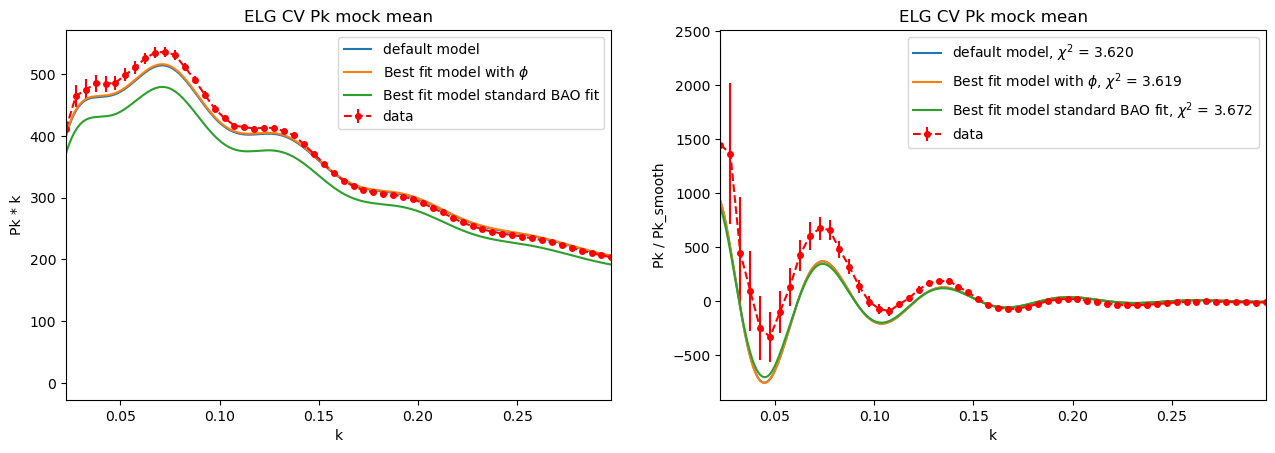

In [112]:
err = np.sqrt(np.diag(dataset_pk.cov[0:56,0:56]))

# make an interpolator 
from scipy.interpolate import CubicSpline 
interp = CubicSpline(k[:,0], pk1[0])

from barry.cosmology.power_spectrum_smoothing import smooth_func, validate_smooth_method # for smoothing data for plot 

pk_smooth_data = smooth_func(
            dataset_pk.ks, 
            dataset_pk.data[:,0], 
            om=0.3152,
            h0=0.7636,
            ob=0.0493,
            ns=0.9649,
            rs=modelBF2.camb.get_data()['r_s'],
            Neff=3.046,
        )  # Get the smoothed power spectrum


# calculate the chi squared for the different models 

interp_default = CubicSpline(kd[:,0], pkd[0]/pkdsmooth[0])
interp_bestfit = CubicSpline(kbf[:,0], pkbf[0]/pkbfsmooth[0])
interp_bestfit_2 = CubicSpline(kbf2[:,0], pkbf2[0]/pkbfsmooth2[0])

default_pk_vals = interp_default(dataset_pk.ks)
bestfit_pk_vals = interp_bestfit(dataset_pk.ks)
bestfit2_pk_vals = interp_bestfit_2(dataset_pk.ks)

# calculate chi squares 
chi_square_default = np.sum( (( default_pk_vals - dataset_pk.data[:,0]/pk_smooth_data ) ** 2) / ((err/pk_smooth_data)**2) ) 
chi_square_bestfit = np.sum( (( bestfit_pk_vals - dataset_pk.data[:,0]/pk_smooth_data ) ** 2) / ((err/pk_smooth_data)**2) ) 
chi_square_bestfit_2 = np.sum( (( bestfit2_pk_vals - dataset_pk.data[:,0]/pk_smooth_data ) ** 2) / ((err/pk_smooth_data)**2) ) 

reduced_chisquare_default = chi_square_default/ (len(dataset_pk.ks - 7.0 ))
reduced_chisquare_bestfit = chi_square_bestfit/ (len(dataset_pk.ks - 7.0 ))
reduced_chisquare_bestfit_2 = chi_square_bestfit_2/ (len(dataset_pk.ks - 7.0 ))


f, (ax1, ax2) = plt.subplots(1,2, sharex=True)


ax1.errorbar(dataset_pk.ks, dataset_pk.data[:,0] * dataset_pk.ks, err * dataset_pk.ks, label='data', color='red', linestyle='--', 
    markersize = 4, marker='o')
ax1.plot(kd[:,0], pkd[0] * kd[:,0], label=r'default model')
ax1.plot(kbf[:,0], pkbf[0] * kbf[:,0], label=r'Best fit model with $\phi$')
ax1.plot(kbf2[:,0], pkbf2[0] * kbf2[:,0], label=r'Best fit model standard BAO fit')
ax1.legend()
ax1.set_title("ELG Pk mock mean")
if CV:
    ax1.set_title("ELG CV Pk mock mean")
ax1.set_xlim(np.min(dataset_pk.ks), np.max(dataset_pk.ks))
ax1.set_ylabel('Pk * k')
ax1.set_xlabel('k')

ax2.errorbar(dataset_pk.ks, dataset_pk.data[:,0]/interp(dataset_pk.ks), err/interp(dataset_pk.ks), label='data', color='red', linestyle='--', 
    markersize = 4, marker='o')
ax2.plot(kd[:,0], pkd[0]/pkdsmooth[0], label=r'default model, $\chi^2$ = %.3f' % reduced_chisquare_default)
ax2.plot(kbf[:,0], pkbf[0]/pkbfsmooth[0], label=r'Best fit model with $\phi$, $\chi^2$ = %.3f' % reduced_chisquare_bestfit)
ax2.plot(kbf2[:,0], pkbf2[0]/pkbfsmooth2[0], label=r'Best fit model standard BAO fit, $\chi^2$ = %.3f' % reduced_chisquare_bestfit_2)
ax2.legend()
ax2.set_title("ELG Pk mock mean")
if CV:
    ax2.set_title("ELG CV Pk mock mean")
ax2.set_xlim(np.min(dataset_pk.ks), np.max(dataset_pk.ks))
ax2.set_ylabel('Pk / Pk_smooth')
ax2.set_xlabel('k')

plt.subplots_adjust(right=2)
plt.show()

